# Description

The notebook builds a DAG with a simple risk model and runs it in the historical mode.

# Imports

In [1]:
import logging

import numpy as np
import pandas as pd
import sklearn.linear_model as slmode

import core.config as cconfig
import core.features as cofeatur
import core.signal_processing as csigproc
import dataflow.core as dtfcore
import helpers.hdbg as hdbg
import helpers.hprint as hprint

/app/amp/core/signal_processing/decorrelation.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-079ac10b-29c4-4fa7-91cc-f5778a9ca42e.json'


# Model configuration

Build a `DagBuilder` object that defines a model's configuration
- `get_config_template()`: creates a configuration for each DAG Node
- `_get_dag()`: specifies all the DAG Nodes and builds a DAG using these Nodes

In [3]:
class SimpleRiskModel_DagBuilder(dtfcore.DagBuilder):
    """
    A pipeline similar to real feature processing.
    """

    @staticmethod
    def get_column_name(tag: str) -> str:
        """
        See description in the parent class.
        """
        raise NotImplementedError

    def get_trading_period(
        self, config: cconfig.Config, mark_key_as_used: bool
    ) -> str:
        """
        See description in the parent class.
        """
        _ = self
        raise NotImplementedError

    def get_required_lookback_in_effective_days(
        self, config: cconfig.Config, mark_key_as_used: bool
    ) -> str:
        """
        See description in the parent class.
        """
        raise NotImplementedError

    def set_weights(
        self, config: cconfig.Config, weights: pd.Series
    ) -> cconfig.Config:
        """
        See description in the parent class.
        """
        raise NotImplementedError

    def convert_to_fast_prod_setup(
        self, config: cconfig.Config
    ) -> cconfig.Config:
        """
        See description in the parent class.
        """
        raise NotImplementedError

    def get_config_template(self) -> cconfig.Config:
        """
        Return a config template compatible with `self.get_dag()`.
        """
        # Set input and output column names that will be passed to the node.
        columns = ["ret_0", "x_1", "x_2"]
        # X vars stands for the input features column names.
        x_vars = [x for x in columns if x != "ret_0"]
        # Y vars stands for the output column name.
        y_vars = ["ret_0"]
        dict_ = {
            self._get_nid("sklearn"): {
                "in_col_groups": [(x,) for x in columns],
                "out_col_group": (),
                "x_vars": x_vars,
                "y_vars": y_vars,
                "steps_ahead": 1,
                "model_kwargs": {
                    "fit_intercept": False,
                },
                "nan_mode": "drop",
            },
            self._get_nid("residualize"): {
                "in_col_groups": [
                    ("ret_0.shift_-1",),
                    ("ret_0.shift_-1_hat",),
                ],
                "out_col_group": (),
                "transformer_kwargs": {
                    "term1_col": "ret_0.shift_-1",
                    "term2_col": "ret_0.shift_-1_hat",
                    "out_col": "residual.shift_-1",
                    "operation": "sub",
                },
            },
            self._get_nid("compute_rolling_norm"): {
                "in_col_group": ("residual.shift_-1",),
                "out_col_group": ("smoothed_squared_residual.shift_-1",),
                "transformer_kwargs": {
                    "tau": 10,
                },
            },
        }
        config = cconfig.Config.from_dict(dict_)
        return config

    def _get_dag(
        self,
        config: cconfig.Config,
        *,
        mode: str = "strict",
    ) -> dtfcore.DAG:
        """
        Build DAG given a `config`.

        :param config: DAG configuration
        :return: resulting `DAG` that is built from an input config
        """
        dag = dtfcore.DAG(mode=mode)
        _LOG.debug("%s", config)
        #
        stage = "sklearn"
        nid = self._get_nid(stage)
        node = dtfcore.MultiindexSkLearnModel(
            nid,
            model_func=slmode.LinearRegression,
            **config[nid].to_dict(),
        )
        dag.append_to_tail(node)
        #
        stage = "residualize"
        nid = self._get_nid(stage)
        node = dtfcore.GroupedColDfToDfTransformer(
            nid,
            transformer_func=cofeatur.combine_columns,
            **config[nid].to_dict(),
        )
        dag.append_to_tail(node)
        #
        stage = "compute_rolling_norm"
        nid = self._get_nid(stage)
        node = dtfcore.SeriesToSeriesTransformer(
            nid,
            transformer_func=csigproc.compute_rolling_norm,
            **config[nid].to_dict(),
        )
        dag.append_to_tail(node)
        #
        return dag

# Build a DAG

In [4]:
dag_builder = SimpleRiskModel_DagBuilder()
dag_config = dag_builder.get_config_template()
print(dag_config)

sklearn: 
  in_col_groups: [('ret_0',), ('x_1',), ('x_2',)]
  out_col_group: ()
  x_vars: ['x_1', 'x_2']
  y_vars: ['ret_0']
  steps_ahead: 1
  model_kwargs: 
    fit_intercept: False
  nan_mode: drop
residualize: 
  in_col_groups: [('ret_0.shift_-1',), ('ret_0.shift_-1_hat',)]
  out_col_group: ()
  transformer_kwargs: 
    term1_col: ret_0.shift_-1
    term2_col: ret_0.shift_-1_hat
    out_col: residual.shift_-1
    operation: sub
compute_rolling_norm: 
  in_col_group: ('residual.shift_-1',)
  out_col_group: ('smoothed_squared_residual.shift_-1',)
  transformer_kwargs: 
    tau: 10


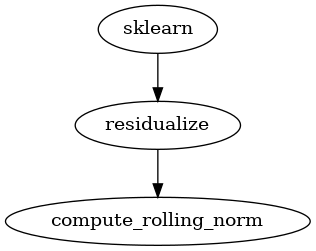

In [5]:
dag = dag_builder.get_dag(dag_config)
dtfcore.draw(dag)

# Generate data and connect data source to the DAG

In [6]:
n_assets = 4
n_features = 2
n_periods = 10
freq = "B"
period_start = "2023-05-01"
rng_seed = 1


def get_random_data(
    n_assets: int,
    n_features: int,
    n_periods: int,
    period_start: str,
    freq: str,
    seed: int,
) -> pd.DataFrame():
    """
    Generate a dataframe of random returns and random features.
    """
    # Create datetime index for dataframe.
    idx = pd.date_range(start=period_start, periods=n_periods, freq=freq)
    # Create columns names for the X matrix.
    cols = [f"x_{k}" for k in range(1, n_features + 1)]
    cols = cols + ["ret_0"]
    # Instantiate random number generator.
    rng = np.random.default_rng(rng_seed)
    dfs = {}
    for n in range(n_assets):
        asset_id = 100 + n
        dfs[asset_id] = pd.DataFrame(
            rng.standard_normal((n_periods, n_features + 1)), idx, cols
        )
    df = pd.concat(dfs, axis=1).swaplevel(axis=1).sort_index(axis=1)
    return df


data = get_random_data(
    n_assets, n_features, n_periods, period_start, freq, rng_seed
)
display(data.head())

ret_0                                     x_1                                     x_2                              
                 100       101       102       103       100       101       102       103       100       101       102       103
2023-05-01  0.330437 -0.377605 -0.982188 -0.094828  0.345584  2.117839  0.054102  0.876242  0.821618 -1.112021  0.272791  0.256486
2023-05-02  0.446375  0.663063 -0.466750 -2.250854 -1.303157  2.042772 -1.107373 -0.258848  0.905356  0.646703  0.199585  1.055743
2023-05-03  0.364572  0.167465 -1.648787 -1.425349 -0.536953 -0.514006  0.235506 -0.138655  0.581118 -1.648075  0.759520  0.033000
2023-05-04  0.546713 -0.683227 -0.297527  0.862445  0.294132  0.109014  0.254388  0.332814  0.028422 -1.227352  1.224647 -0.651281
2023-05-05 -0.482119 -0.098270  0.253447  1.218844 -0.736454 -0.072044 -0.810815 -0.125592 -0.162910 -0.944752  0.752244  0.669153

Wrap the data into a `DfDataSource` that serves as a DAG source Node.

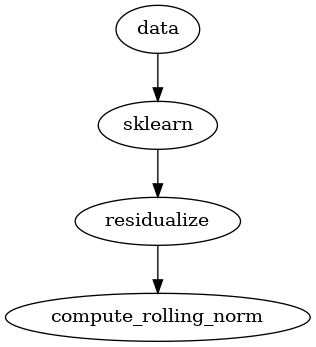

In [7]:
node = dtfcore.DfDataSource("data", data)
dag.insert_at_head(node)
dtfcore.draw(dag)

# Run the DAG

In [8]:
dag_runner = dtfcore.FitPredictDagRunner(dag)
dag_runner.set_fit_intervals(
    [
        (
            data.index.min(),
            data.index.max(),
        )
    ],
)
fit_result_bundle = dag_runner.fit()
#
result_df = fit_result_bundle.result_df
result_df.head()

run_leq_node:   0%|          | 0/4 [00:00<?, ?it/s]

/app/amp/helpers/hdbg.py:292: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values
/app/amp/core/signal_processing/ema_smoothing.py:65: FutureWarning: The 'axis' keyword in Series.ewm is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  signal_hat = signal_hat.ewm(


smoothed_squared_residual.shift_-1                               residual.shift_-1                               ret_0.shift_-1                               ret_0.shift_-1_hat                                   ret_0                                     x_1                                     x_2                              
                                          100       101       102       103               100       101       102       103            100       101       102       103                100       101       102       103       100       101       102       103       100       101       102       103       100       101       102       103
2023-05-01                           0.406651  0.666367  0.549490  1.721813          0.406651  0.666367 -0.549490 -1.721813       0.446375  0.663063 -0.466750 -2.250854           0.039724 -0.003303  0.082740 -0.529041  0.330437 -0.377605 -0.982188 -0.094828  0.345584  2.117839  0.054102  0.876242  0.821618 -1.112021  0.272791  0.256486
2023-05-02                           0.282050  0.474125  0.479592  1.197966         -0.043662 -0.162506 -0.406108 -0.226181       0.364572  0.167465 -1.648787 -1.425349           0.408234  0.329971 -1.242679 -1.199168  0.446375  0.663063 -0.466750 -2.250854 -1.303157  2.042772 -1.107373 -0.258848  0.905356  0.646703  0.199585  1.055743
2023-05-03                           0.308534  0.422001  0.537284  1.088170          0.349502 -0.312376 -0.624330  0.866880       0.546713 -0.683227 -0.297527  0.862445           0.197211 -0.370850  0.326803 -0.004435  0.364572  0.167465 -1.648787 -1.425349 -0.536953 -0.514006  0.235506 -0.138655  0.581118 -1.648075  0.759520  0.033000
2023-05-04                           0.345286  0.362570  0.458593  0.959814         -0.422422  0.128637 -0.131074  0.522907      -0.482119 -0.098270  0.253447  1.218844          -0.059698 -0.226907  0.384520  0.695936  0.546713 -0.683227 -0.297527  0.862445  0.294132  0.109014  0.254388  0.332814  0.028422 -1.227352  1.224647 -0.651281
2023-05-05                           0.367326  0.351874  0.502164  0.912414         -0.429141 -0.316006 -0.619186 -0.744521      -0.292457 -0.506292 -1.481818 -1.514319           0.136685 -0.190286 -0.862632 -0.769797 -0.482119 -0.098270  0.253447  1.218844 -0.736454 -0.072044 -0.810815 -0.125592 -0.162910 -0.944752  0.752244  0.669153